# Sentiment analysis using different ML and DL algorithms

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import re, numpy as np, pandas as pd

In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\69785hsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [5]:
# For ML algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import RidgeClassifier

In [6]:
df=pd.read_csv("sentiment.csv")

In [7]:
df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [8]:
# Keeping only the neccessary columns
df = df[['text','sentiment']]
df.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [9]:
df.shape

(13871, 2)

In [10]:
df.sentiment.value_counts()

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

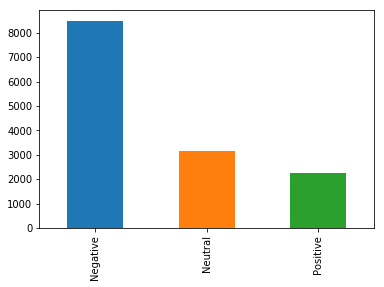

In [11]:
df.sentiment.value_counts().plot(kind='bar')

In [12]:
df['labels'] = df.sentiment.map({'Negative':0, 'Positive':1, 'Neutral':2})
#y=pd.get_dummies(df['sentiment']).values

In [13]:
df['labels'][:5]

0    2
1    1
2    2
3    1
4    1
Name: labels, dtype: int64

In [14]:
[print(df['sentiment'][i], df['labels'][i]) for i in range(0,5)]

Neutral 2
Positive 1
Neutral 2
Positive 1
Positive 1


[None, None, None, None, None]

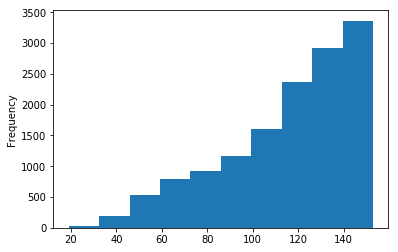

In [15]:
df['text'].str.len().plot.hist()

In [16]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [17]:
df['cleaned']=[text_prepare(x) for x in df['text']]

In [18]:
print(df.text[:5])

0    RT @NancyLeeGrahn: How did everyone feel about...
1    RT @ScottWalker: Didn't catch the full #GOPdeb...
2    RT @TJMShow: No mention of Tamir Rice and the ...
3    RT @RobGeorge: That Carly Fiorina is trending ...
4    RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
Name: text, dtype: object


In [19]:
df.cleaned[:5]

0    nancyleegrahn everyone feel climate change que...
1    scottwalker didnt catch full gopdebate last ni...
2    tjmshow mention tamir rice gopdebate held clev...
3    robgeorge carly fiorina trending hours debate ...
4    danscavino gopdebate w realdonaldtrump deliver...
Name: cleaned, dtype: object

### most common words

In [20]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in df['cleaned'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('gopdebate', 8997),
 ('gopdebates', 5262),
 ('tco', 3627),
 ('rwsurfergirl', 1975),
 ('trump', 1781),
 ('fox', 1305),
 ('realdonaldtrump', 1063),
 ('debate', 1048),
 ('amp', 1038),
 ('news', 908)]

# Splitting data

Split X and y into training and testing sets

In [21]:
X=df['cleaned']
y=df['labels']

In [22]:
X.head()

0    nancyleegrahn everyone feel climate change que...
1    scottwalker didnt catch full gopdebate last ni...
2    tjmshow mention tamir rice gopdebate held clev...
3    robgeorge carly fiorina trending hours debate ...
4    danscavino gopdebate w realdonaldtrump deliver...
Name: cleaned, dtype: object

In [23]:
y[:5]

0    2
1    1
2    2
3    1
4    1
Name: labels, dtype: int64

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10403,)
(3468,)
(10403,)
(3468,)


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test - input text       
        return TF-IDF vectorizer for each dataset
    """
    
    # filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the tweets)
    # ngram!!! -->  ngram_range=(1,2)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern='(\S+)')
    
    # Fit and transform the vectorizer on the train set
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    
    # Only Transform the test sets 
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_
    
    
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)

In [26]:
# convert to dense array
X_train_tfidf=X_train_tfidf.toarray()

In [27]:
type(X_train_tfidf)

numpy.ndarray

In [28]:
X_test_tfidf=X_test_tfidf.toarray()

In [29]:
y_train[:5]

10860    2
12777    2
8361     0
13672    2
10473    0
Name: labels, dtype: int64

# 3 Model

In [30]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_tfidf,y_train)
predmnb = mnb.predict(X_test_tfidf)

### Comparing y-predict and y test results

In [31]:
predmnb

array([2, 2, 1, ..., 0, 2, 2], dtype=int64)

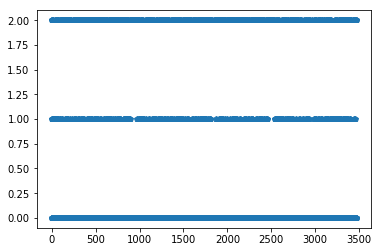

In [32]:
import matplotlib.pyplot as plt
plt.plot(predmnb, "p")

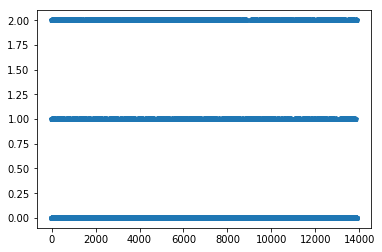

In [33]:
plt.plot(y_test, "p")

### Making the confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predmnb)
cm

array([[1898,   55,  185],
       [ 294,  187,   68],
       [ 477,   53,  251]], dtype=int64)

### Checking accuracy score

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predmnb)

0.6735870818915801

In [36]:
from sklearn.metrics import classification_report
print (classification_report(y_test, predmnb))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      2138
           1       0.63      0.34      0.44       549
           2       0.50      0.32      0.39       781

   micro avg       0.67      0.67      0.67      3468
   macro avg       0.61      0.52      0.54      3468
weighted avg       0.65      0.67      0.64      3468



# 4)-LSTM

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

In [38]:
df.head()

,text,sentiment,labels,cleaned
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral,2,nancyleegrahn everyone feel climate change que...
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive,1,scottwalker didnt catch full gopdebate last ni...
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral,2,tjmshow mention tamir rice gopdebate held clev...
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive,1,robgeorge carly fiorina trending hours debate ...
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive,1,danscavino gopdebate w realdonaldtrump deliver...


In [39]:
Y=df['sentiment']

In [40]:
y_train, y_test = train_test_split(Y, random_state=1)

In [41]:
y_train.shape

(10403,)

In [42]:
y_test.shape

(3468,)

In [43]:
y_train[:5]

10860     Neutral
12777     Neutral
8361     Negative
13672     Neutral
10473    Negative
Name: sentiment, dtype: object

In [44]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

**this step is very important as we need to decode categorical variables into dummy**

In [45]:
y_train_ohe[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [46]:
y_test_ohe[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [47]:
df['text'].shape

(13871,)

In [48]:
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
X_train_tfidf.shape

(10403, 4568)

In [50]:
X_train_tfidf.shape[0]

10403

In [51]:
X_train_tfidf.shape[1]

4568

In [52]:
X=[text_prepare(x) for x in df['text']]

In [53]:
X[:5]

['nancyleegrahn everyone feel climate change question last night exactly gopdebate',
 'scottwalker didnt catch full gopdebate last night scotts best lines 90 seconds walker16 tco zsff',
 'tjmshow mention tamir rice gopdebate held cleveland wow',
 'robgeorge carly fiorina trending hours debate men justcompleted gopdebate says shes',
 'danscavino gopdebate w realdonaldtrump delivered highest ratings history presidential debates trump2016 tco']

In [55]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

In [56]:
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  248,  348,  340,  281,   46,   11,   18,
         910,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         251,   57, 1818,  485,    1,   11,   18,   97, 1290, 1433, 1217,
         723,    3],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  386,    1, 1666,
         580,  419],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  202,  156,  616,    8,  102,    1,
         129,  668],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 1066,    1,  132,    7, 1999, 1553,  150,  541,   98,  106,
         294,    3]])

In [57]:
X.shape

(13871, 24)

tfidf had (10403, 4568)and X has (13871, 24)<br>

We will choose for fast computing X for now.

In [64]:
X_train, X_test = train_test_split(X, random_state=1)

In [66]:
X_train.shape, X_test.shape

((10403, 24), (3468, 24))

### Create LSTM model

In [67]:
embed_dim = 128
lstm_out = 196
max_fatures = 2000

In [68]:
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
# X.shape[1] refers to 24 columns 
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 128)           256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 24, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


**Train the LSTM model for 20 epochs**

In [60]:
batch_size = 32
epochs = 20

In [61]:
from keras.callbacks import EarlyStopping

In [69]:
history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Instructions for updating:
Use tf.cast instead.
Train on 9362 samples, validate on 1041 samples
Epoch 1/20
9362/9362 [==============================] - 9s 915us/step - loss: 0.8397 - acc: 0.6385 - val_loss: 0.7437 - val_acc: 0.6724
Epoch 2/20
9362/9362 [==============================] - 7s 742us/step - loss: 0.6952 - acc: 0.6979 - val_loss: 0.7498 - val_acc: 0.6695
Epoch 3/20
9362/9362 [==============================] - 7s 734us/step - loss: 0.6402 - acc: 0.7216 - val_loss: 0.7423 - val_acc: 0.6782
Epoch 4/20
9362/9362 [==============================] - 7s 736us/step - loss: 0.5991 - acc: 0.7421 - val_loss: 0.7542 - val_acc: 0.6772
Epoch 5/20
9362/9362 [==============================] - 7s 734us/step - loss: 0.5655 - acc: 0.7545 - val_loss: 0.7682 - val_acc: 0.6647
Epoch 6/20
9362/9362 [==============================] - 7s 732us/step - loss: 0.5347 - acc: 0.7737 - val_loss: 0.8282 - val_acc: 0.6523


In [70]:
y_pred = model.predict(X_test)

In [71]:
y_pred[:5]

array([[0.13016555, 0.85156536, 0.01826905],
       [0.11046693, 0.86971796, 0.01981508],
       [0.01087797, 0.0187332 , 0.9703888 ],
       [0.9313132 , 0.05423479, 0.01445209],
       [0.96064866, 0.03198193, 0.00736931]], dtype=float32)

In [72]:
y_test_ohe[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [73]:
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [74]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      2138
           1       0.43      0.48      0.45       781
           2       0.54      0.48      0.51       549

   micro avg       0.65      0.65      0.65      3468
   macro avg       0.58      0.57      0.57      3468
weighted avg       0.65      0.65      0.65      3468



In [75]:
print(confusion_matrix(y_test_class,y_pred_class))

[[1614  393  131]
 [ 311  373   97]
 [ 186   97  266]]


In [77]:
loss, accuracy = model.evaluate(X_train, y_train_ohe, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.7927
Training Loss: 0.4985


In [78]:
loss, accuracy = model.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.6497
Testing Loss:  0.8395


In [79]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

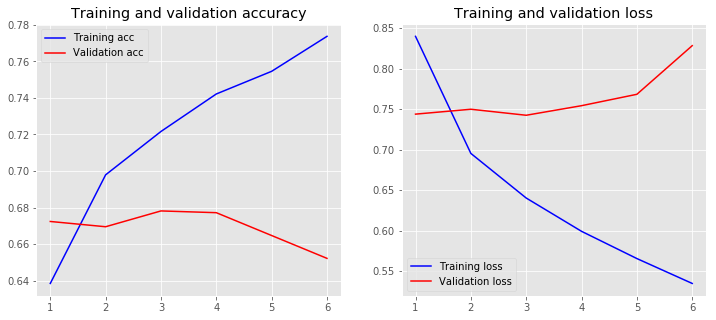

In [80]:
plot_history(history)

In [82]:
[print(df['text'][i], y_pred[i], y_test_ohe[i]) for i in range(0, 5)]

RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate [0.13016555 0.85156536 0.01826905] [0. 1. 0.]
RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF… [0.11046693 0.86971796 0.01981508] [0. 1. 0.]
RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow. [0.01087797 0.0187332  0.9703888 ] [0. 0. 1.]
RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on … [0.9313132  0.05423479 0.01445209] [1. 0. 0.]
RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co… [0.96064866 0.03198193 0.00736931] [1. 0. 0.]


[None, None, None, None, None]

In [83]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, y_pred in enumerate(y_pred):
    if np.argmax(y_pred)==2:
        pos_count += 1
    elif np.argmax(y_pred)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test_ohe[i])==2:
        real_pos += 1
    elif np.argmax(y_test_ohe[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 494
Neutral predictions: 863
Negative predictions: 2111
Real positive: 549
Real neutral: 781
Real negative: 2138
